In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emodata-v2/emodata_v2.csv


1. Importing necessary libraries

In [2]:
!pip install --upgrade pip
!pip install scikit-plot
!pip install --upgrade tensorflow
!pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3.2
    Uninstalling pip-23.3.2:
      Successfully uninstalled pip-23.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 58.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 116.1 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1
  Attemp

In [3]:
import pandas as pd
import numpy as np
import scikitplot
import random
import seaborn as sns
import keras
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import warnings
from tensorflow.keras.models import Sequential
from keras import regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.utils import plot_model
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.simplefilter("ignore")
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.regularizers import l1, l2
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

2024-08-03 07:41:30.114917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 07:41:30.136128: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 07:41:30.142527: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2. Loading the data

In [4]:
data = pd.read_csv("/kaggle/input/emodata-v2/emodata_v2.csv")
data.shape

(49387, 3)

In [5]:
data.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [6]:
data.head()

,emotion,pixels,Usage
0,4,207 213 218 220 217 211 146 60 44 55 72 69 66 ...,train
1,0,0 0 0 0 0 0 0 0 0 0 0 0 1 0 64 174 159 198 240...,test
2,6,255 255 255 255 255 255 255 255 255 255 255 25...,train
3,4,231 230 230 231 184 166 169 173 175 175 177 18...,test
4,4,112 120 128 89 56 37 66 76 76 70 50 65 94 90 8...,train


3. Data pre-processing

In [7]:
CLASS_LABELS  = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', "surprised"]
fig = px.bar(x = CLASS_LABELS,
             y = [list(data['emotion']).count(i) for i in np.unique(data['emotion'])] ,
             color = np.unique(data['emotion']) ,
             color_continuous_scale="Emrld")
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

3.1 Shuffling the data

In [8]:
data = data.sample(frac=1).reset_index(drop=True)

3.2 One Hot Encoding

In [9]:
labels = to_categorical(data[['emotion']], num_classes=7)

In [10]:
pixels = np.array([np.fromstring(p, sep=' ') for p in data['pixels']], dtype='float32').reshape((data.shape[0], 48, 48, 1))

In [11]:
# Chuẩn hóa dữ liệu pixel
scaler = StandardScaler()
pixels = scaler.fit_transform(pixels.reshape((data.shape[0], -1))).reshape((data.shape[0], 48, 48, 1))

3.5 Train test validation split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [13]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(40003, 48, 48, 1)
(4939, 48, 48, 1)
(4445, 48, 48, 1)


3.6 Data augmentation using ImageDataGenerator

In [14]:
datagen = ImageDataGenerator(  width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)
valgen = ImageDataGenerator(   width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)

In [15]:
datagen.fit(X_train)
valgen.fit(X_val)

In [16]:
train_generator = datagen.flow(X_train, y_train, batch_size=64)
val_generator = datagen.flow(X_val, y_val, batch_size=64)

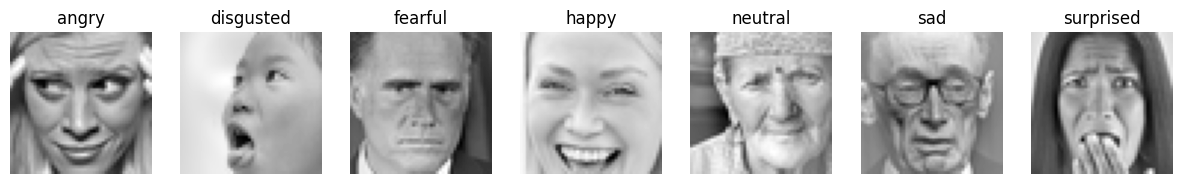

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Hiển thị mỗi một ảnh ngẫu nhiên tương ứng với 7 class
plt.figure(figsize=(15, 23))
label_dict = {0: 'angry', 1: 'disgusted', 2: 'fearful', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprised'}

# Lặp qua từng class
for i in range(7):
    # Lọc các chỉ số của ảnh thuộc class hiện tại
    class_indices = np.where(np.argmax(y_train, axis=1) == i)[0]
    # Chọn ngẫu nhiên một chỉ số từ class hiện tại
    random_index = np.random.choice(class_indices)
    # Lấy ảnh ngẫu nhiên từ class hiện tại
    img = np.squeeze(X_train[random_index])
    
    # Hiển thị ảnh
    plt.subplot(1, 7, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(CLASS_LABELS[i])
    plt.axis('off')

plt.show()


4. Design a model

4.1 CNN mode

In [18]:
def cnn_model():

  model= tf.keras.models.Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
  model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(256,activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Dense(512,activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Dense(7, activation='softmax'))
  model.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
  return model

In [19]:
model = cnn_model()

I0000 00:00:1722670939.207578      34 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722670939.340944      34 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722670939.341212      34 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722670939.343693      34 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,810,183 (22.16 MB)

 Trainable params: 5,805,191 (22.15 MB)

 Non-trainable params: 4,992 (19.50 KB)

4.2 Early stopping

In [21]:
checkpointer = [
    EarlyStopping(
        monitor='accuracy',  # Sử dụng accuracy để theo dõi
        verbose=1,
        restore_best_weights=True,
        mode="max",
        patience=10  # Tăng patience để cho mô hình thêm thời gian học
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor="accuracy",  # Sử dụng accuracy để theo dõi
        verbose=1,
        save_best_only=True,
        mode="max"
    ),
    ReduceLROnPlateau(
        monitor='loss',  # Sử dụng loss để giảm learning rate
        factor=0.2,
        patience=10,
        min_lr=0.00001,
        verbose=1
    )
]

In [22]:
history = model.fit(train_generator,
                    epochs=200,
                    batch_size=64,
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/200


I0000 00:00:1722670945.525124     109 service.cc:146] XLA service 0x7e7f70003150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722670945.525187     109 service.cc:154]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-08-03 07:42:27.762398: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 0: 1.16473, expected 0.928603
2024-08-03 07:42:27.762462: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 8: 1.1794, expected 0.943274
2024-08-03 07:42:27.762472: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 9: 0.892153, expected 0.656024
2024-08-03 07:42:27.762480: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 10: 1.163, expected 0.926874
2024-08-03 07:42:27.762488: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 11: 1.33797, expected 1.10184
2024-08-03 07:42:27.762496: E

  5/626 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.1493 - loss: 15.0766  

I0000 00:00:1722670954.899660     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1745 - loss: 14.4326

2024-08-03 07:42:57.814695: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 0: 1.16473, expected 0.928603
2024-08-03 07:42:57.814759: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 8: 1.1794, expected 0.943274
2024-08-03 07:42:57.814768: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 9: 0.892153, expected 0.656024
2024-08-03 07:42:57.814777: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 10: 1.163, expected 0.926874
2024-08-03 07:42:57.814795: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 11: 1.33797, expected 1.10184
2024-08-03 07:42:57.814803: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 13: 1.18042, expected 0.944295
2024-08-03 07:42:57.814811: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 19: 1.28869, expected 1.05256
2024-08-03 07:42:57.814819: E external/local_xla/xla/se


Epoch 1: accuracy improved from -inf to 0.18284, saving model to best_model.keras
626/626 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - accuracy: 0.1745 - loss: 14.4317 - val_accuracy: 0.2263 - val_loss: 12.4749 - learning_rate: 1.0000e-04
Epoch 2/200
625/626 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2137 - loss: 12.1522
Epoch 2: accuracy improved from 0.18284 to 0.22451, saving model to best_model.keras
626/626 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.2137 - loss: 12.1504 - val_accuracy: 0.1766 - val_loss: 10.6991 - learning_rate: 1.0000e-04
Epoch 3/200
625/626 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2475 - loss: 9.8910
Epoch 3: accuracy improved from 0.22451 to 0.25293, saving model to best_model.keras
626/626 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.2475 - loss: 9.8893 - val_accuracy: 0.1717 - val_loss: 8.8835 - learning_rate: 1.0000e-04
Epoch 4/200
625/626 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2735 - loss: 7.8484
Epoch 4: accuracy improved from 0.252

Lưu lại model với json và h5

In [ ]:
# Saving the  model
fer_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)

model.save_weights("fer.weights.h5")

4.3 Visualizing results

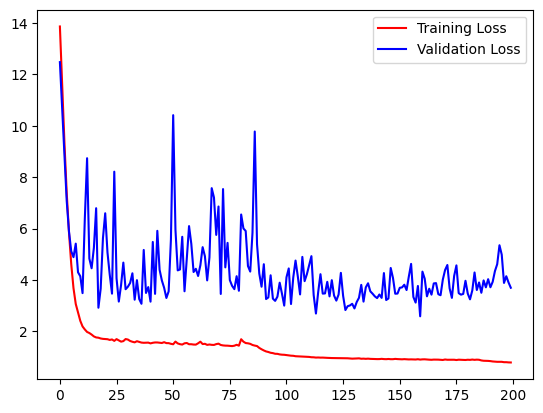

In [24]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

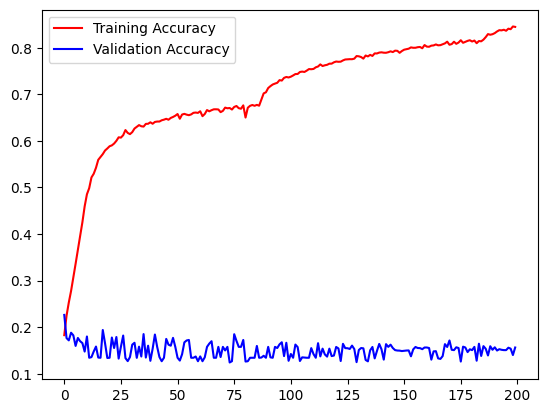

In [25]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

In [26]:
loss = model.evaluate(X_test,y_test)
print("Test Acc: " + str(loss[1]))

2024-08-03 08:41:36.925943: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 0: 1.50943, expected 0.828027
2024-08-03 08:41:36.926001: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 1: 2.3861, expected 1.7047
2024-08-03 08:41:36.926010: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 2: 2.56358, expected 1.88218
2024-08-03 08:41:36.926018: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 3: 2.00481, expected 1.3234
2024-08-03 08:41:36.926026: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 4: 2.42337, expected 1.74196
2024-08-03 08:41:36.926034: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 5: 2.52413, expected 1.84272
2024-08-03 08:41:36.926042: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 6: 1.7751, expected 1.0937
2024-08-03 08:41:36.926049: E external/local_xla/xla/service/gpu/b

143/155 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1641 - loss: 3.7833

2024-08-03 08:41:38.739633: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 0: 1.85393, expected 1.43396
2024-08-03 08:41:38.739690: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 1: 2.55814, expected 2.13818
2024-08-03 08:41:38.739715: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 2: 2.96231, expected 2.54235
2024-08-03 08:41:38.739732: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 3: 2.88718, expected 2.46722
2024-08-03 08:41:38.739743: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 4: 2.69221, expected 2.27225
2024-08-03 08:41:38.739754: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 5: 2.80651, expected 2.38655
2024-08-03 08:41:38.739765: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 6: 2.23069, expected 1.81073
2024-08-03 08:41:38.739776: E external/local_xla/xla/service/g

155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1639 - loss: 3.7869
Test Acc: 0.16278599202632904


In [27]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


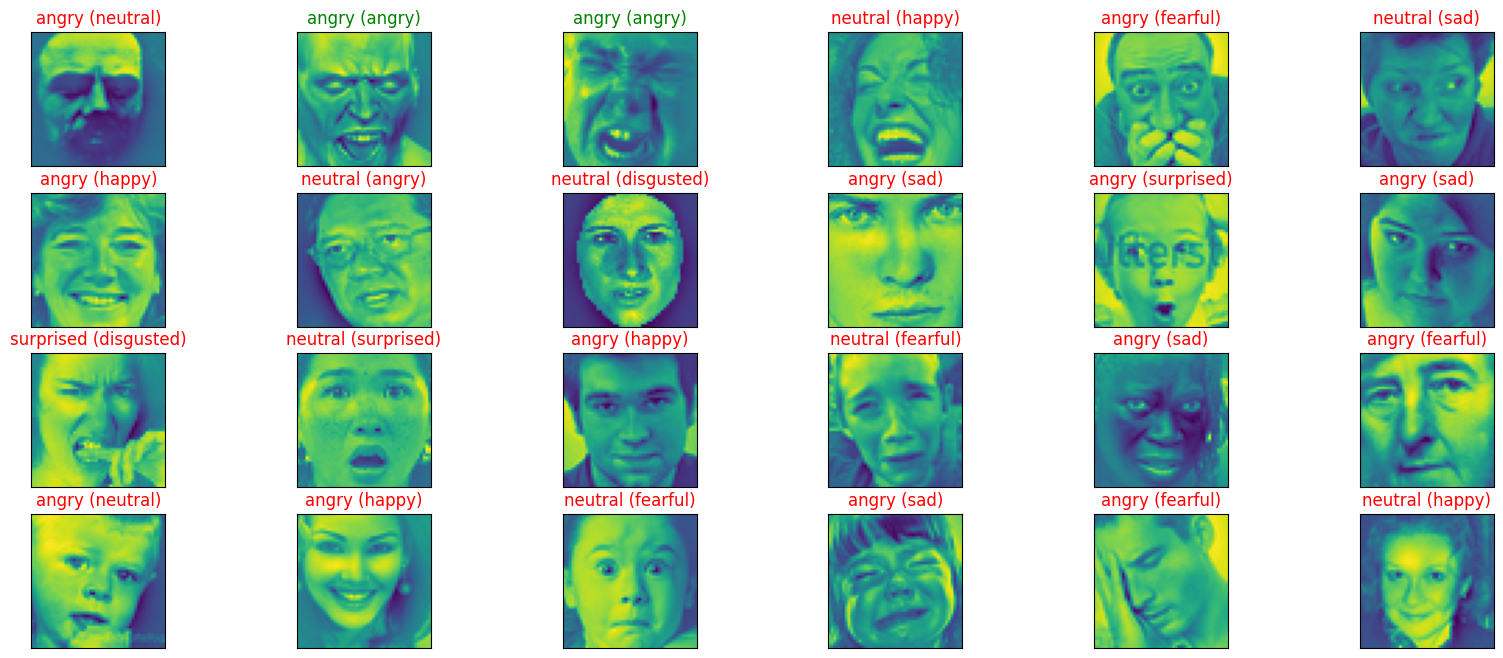

In [28]:
label_dict = {0 : 'angry', 1 : 'disgusted', 2 : 'fearful', 3 : 'happy', 4 : 'neutral', 5 : 'sad', 6 : 'surprised'}

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]

    ax.set_title("{} ({})".format((predict_index),
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

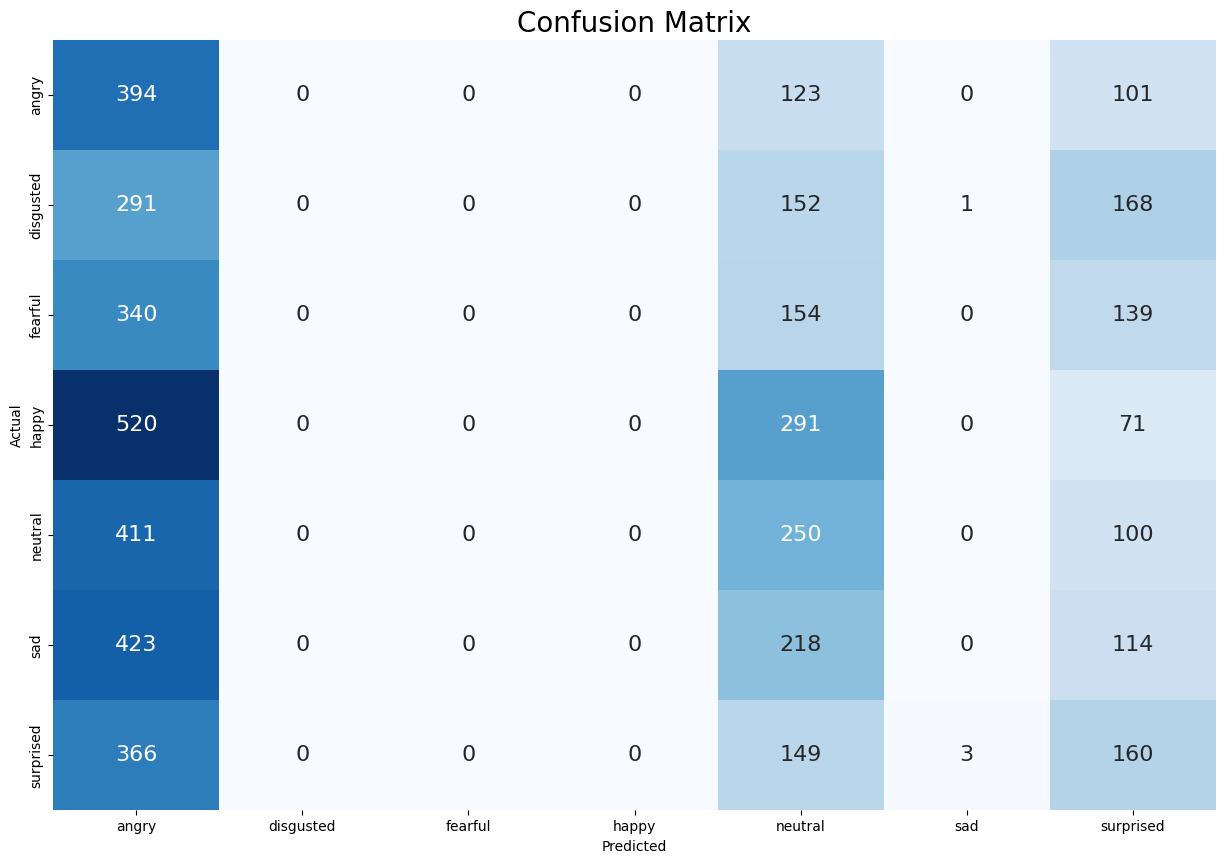

In [29]:
CLASS_LABELS  = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', "surprised"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (15,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [30]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.144     0.638     0.234       618
           1      0.000     0.000     0.000       612
           2      0.000     0.000     0.000       633
           3      0.000     0.000     0.000       882
           4      0.187     0.329     0.238       761
           5      0.000     0.000     0.000       755
           6      0.188     0.236     0.209       678

    accuracy                          0.163      4939
   macro avg      0.074     0.172     0.097      4939
weighted avg      0.073     0.163     0.095      4939



5. Fine tuning

5.1 Changing optimizer

In [31]:
model = cnn_model()

In [32]:
model.compile(optimizer=tf.keras.optimizers.SGD(0.001),
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

In [33]:
history = model.fit(train_generator,
                    epochs=200,
                    batch_size=64,
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/200
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.1558 - loss: 14.9455
Epoch 1: accuracy did not improve from 0.84574
626/626 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - accuracy: 0.1558 - loss: 14.9452 - val_accuracy: 0.1849 - val_loss: 14.0198 - learning_rate: 0.0010
Epoch 2/200
624/626 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1770 - loss: 14.3410
Epoch 2: accuracy did not improve from 0.84574
626/626 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.1771 - loss: 14.3405 - val_accuracy: 0.2047 - val_loss: 13.7073 - learning_rate: 0.0010
Epoch 3/200
624/626 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1865 - loss: 13.9397
Epoch 3: accuracy did not improve from 0.84574
626/626 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.1865 - loss: 13.9392 - val_accuracy: 0.2261 - val_loss: 13.3400 - learning_rate: 0.0010
Epoch 4/200
625/626 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1945 - loss: 13.5801
Epoch 4: accuracy did not improve from 0.84574
626/626 ━━━━━━━━━━━━━

In [34]:
loss = model.evaluate(X_test,y_test)
print("Test Acc: " + str(loss[1]))

155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1833 - loss: 14.0424
Test Acc: 0.1866774708032608


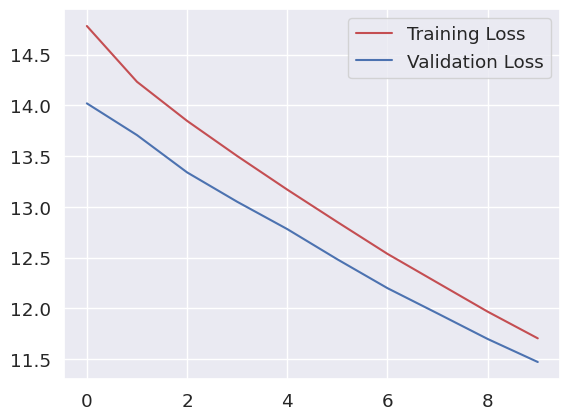

In [35]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

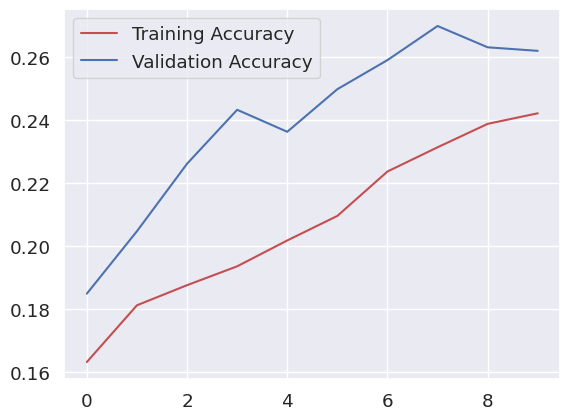

In [36]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

5.2 Changing epoch number

In [37]:
model = cnn_model()

In [38]:
model.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [39]:
checkpointer = [
    EarlyStopping(
        monitor='accuracy',  # Sử dụng accuracy để theo dõi
        verbose=1,
        restore_best_weights=True,
        mode="max",
        patience=10  # Tăng patience để cho mô hình thêm thời gian học
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor="accuracy",  # Sử dụng accuracy để theo dõi
        verbose=1,
        save_best_only=True,
        mode="max"
    ),
    ReduceLROnPlateau(
        monitor='loss',  # Sử dụng loss để giảm learning rate
        factor=0.2,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
]

In [ ]:
history = model.fit(train_generator,
                    epochs=300,
                    batch_size=64,
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/300
389/626 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.1691 - loss: 14.6864

In [ ]:
loss = model.evaluate(X_test,y_test)
print("Test Acc: " + str(loss[1]))

In [ ]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

In [ ]:
CLASS_LABELS  = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', "surprised"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [ ]:
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))